# 2025-09-05 Rootfinding

## Last time

* Forward and backward error
* Forward and backward stability
* Computing volume of a polygon
* Goal-setting and activity
* Discussion of errors

## Today

* Rootfinding as a modeling tool
* Use [Roots.jl](https://juliapackages.com/p/roots) to solve
* Introduce Bisection
* Convergence classes
* Intro to Newton methods

In [16]:
using Plots
default(linewidth=4)

# Rootfinding

> Given $f(x)$, find $x$ such that $f(x) = 0$.

We'll work with scalars ($f$ and $x$ are just numbers) for now, and revisit later when they vector-valued.

## Change inputs to outputs

* $f(x; b) = x^2 - b$
  * $x(b) = \sqrt{b}$
* $f(x; b) = \tan x - b$
  * $x(b) = \arctan b$
* $f(x) = \cos x + x - b$
  * $x(b) = ?$

We aren't given $f(x)$, but rather an algorithm `f(x)` that approximates it.
* Sometimes we get extra information, like `fp(x)` that approximates $f'(x)$
* If we have source code for `f(x)`, maybe it can be transformed "automatically"

# Nesting matryoshka dolls of rootfinding

* I have a function (pressure, temperature) $\mapsto$ (density, energy)
  * I need (density, energy) $\mapsto$ (pressure, temperature)
* I know what condition is satisfied across waves, but not the state on each side. 

![](../img/Toro-ShockOrRarefaction-2.19.png)

*Toro (2009)*

* Given a proposed state, I can measure how much (mass, momentum, energy) is not conserved.
  * Find the solution that conserves exactly
* I can compute lift given speed and angle of attack
  * How much can the plane lift?
  * How much can it lift on a short runway?
![](../img/Boeing_A2_isoQspeed2_lowRes.png)

# Discuss: rootfinding and inverse problems

* Inverse kinematics for robotics
  * (statics) how much does each joint an robotic arm need to move to grasp an object
  * (with momentum) fastest way to get there (motors and arms have finite strength)
  * similar for virtual reality
* Infer a light source (or lenses/mirrors) from an iluminated scene
* Imaging
  * radiologist seeing an x-ray is mentally inferring 3D geometry from 2D image
  * computed tomography (CT) reconstructs 3D model from multiple 2D x-ray images
  * seismology infers subsurface/deep earth structure from seismograpms

# Example: Queueing

In a [simple queueing model](https://en.wikipedia.org/wiki/Queueing_theory#Simple_two-equation_queue), there is an arrival rate and a departure (serving) rate.  While waiting in the queue, there is a probability of "dropping out". The length of the queue in this model is

$$ \text{length} = \frac{\text{arrival} - \text{drop}}{\text{departure}} $$

One model for the waiting time (where these rates are taken from exponential distributions) is

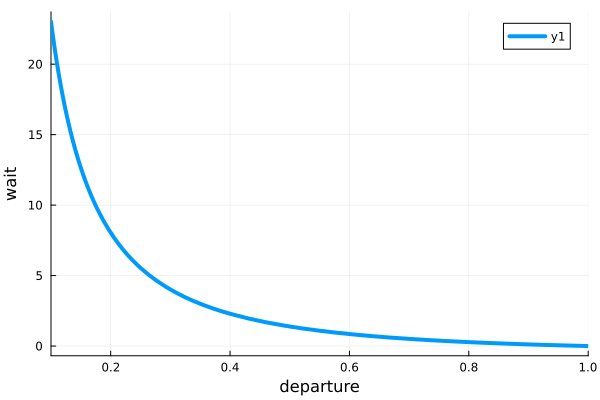

In [17]:
wait(arrival, departure) = log(arrival / departure) / departure

plot(d -> wait(1, d), xlims=(.1, 1), xlabel="departure", ylabel="wait")

# Departure rate given wait

* Easy to measure wait
* I have a limited tolerance for waiting

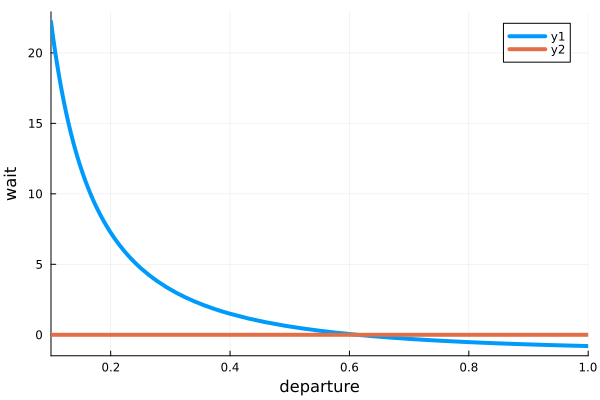

In [18]:
my_wait = 0.8
plot([d -> wait(1, d) - my_wait, d -> 0], xlims=(.1, 1), xlabel="departure", ylabel="wait")

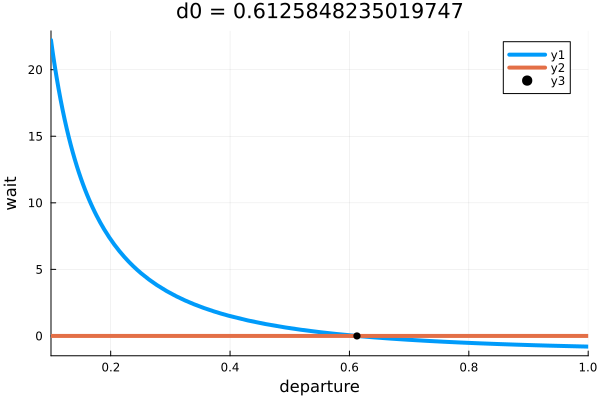

In [19]:
#import Pkg; Pkg.add("Roots")
using Roots
d0 = find_zero(d -> wait(1, d) - my_wait, 1)
plot([d -> wait(1, d) - my_wait, d -> 0], xlims=(.1, 1), xlabel="departure", ylabel="wait")
scatter!([d0], [0], marker=:circle, color=:black, title="d0 = $d0")

# Example: Nonlinear Elasticity

## Strain-energy formulation

$$ \psi = C_1 (I_1 - 3 - 2 \log J) + D_1 (J - 1)^2 $$
where $I_1 = \lambda_1^2 + \lambda_2^2 + \lambda_3^3$ and $J = \lambda_1 \lambda_2 \lambda_3$ are *invariants* defined in terms of the principle stretches $\lambda_i$.

### [Uniaxial extension](https://en.wikipedia.org/wiki/Neo-Hookean_solid#Compressible_neo-Hookean_material_3)

In the experiment, we would like to know the stress as a function of the stretch $\lambda_1$. We don't know $J$, and will have to determine it by solving an equation.

https://www.youtube.com/watch?v=9N5SS8f1auI&t=60

# How much does the volume change?

Using symmetries of uniaxial extension, we can write an equation $f(\lambda, J) = 0$ that must be satisfied. We'll need to solve a rootfinding problem to compute $J(\lambda)$.

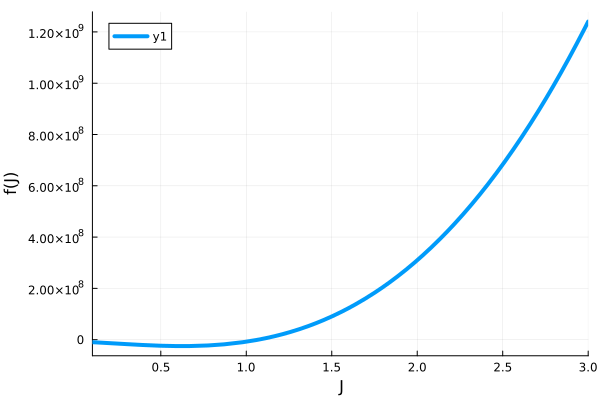

In [20]:
function f(lambda, J)
    C_1 = 1.5e6
    D_1 = 1e8
    D_1 * J^(8/3) - D_1 * J^(5/3) + C_1 / (3*lambda) * J - C_1 * lambda^2/3
end
plot(J -> f(4, J), xlims=(0.1, 3), xlabel="J", ylabel="f(J)")

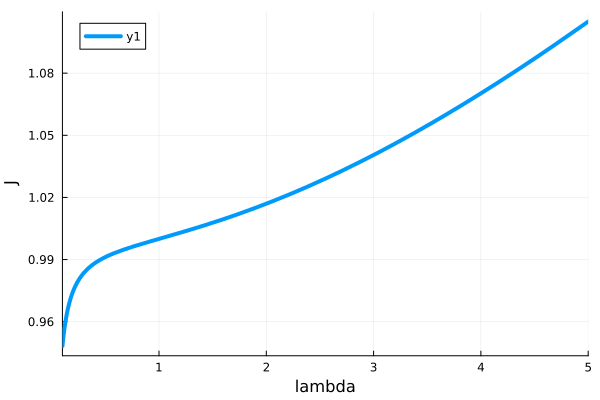

In [21]:
find_J(lambda) = find_zero(J -> f(lambda, J), 1)
plot(find_J, xlims=(0.1, 5), xlabel="lambda", ylabel="J")

# An algorithm: Bisection

Bisection is a rootfinding technique that starts with an interval $[a,b]$ containing a root and does not require derivatives. Suppose $f$ is continuous. What is a **sufficient** condition for $f$ to have a root on $[a,b]$?

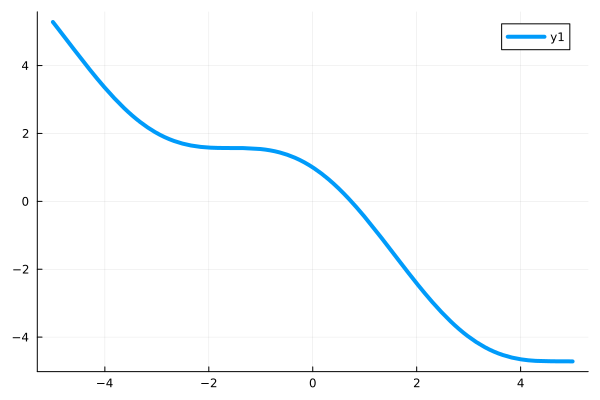

In [22]:
hasroot(f, a, b) = f(a) * f(b) < 0

f(x) = cos(x) - x
plot(f)

# Bisection

In [35]:
function bisect(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return mid
    elseif hasroot(f, a, mid)
        return bisect(f, a, mid, tol)
    else
        return bisect(f, mid, b, tol)
    end
end

x0 = bisect(f, -1, 3, 1e-5)
x0, f(x0)

(0.7390861511230469, -1.7035832658995886e-6)

# How fast does it converge?

In [24]:
function bisect_hist(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return [mid]
    elseif hasroot(f, a, mid)
        return prepend!(bisect_hist(f, a, mid, tol), [mid])
    else
        return prepend!(bisect_hist(f, mid, b, tol), [mid])
    end
end

bisect_hist (generic function with 1 method)

In [25]:
bisect_hist(f, -1, 3, 1e-4)

17-element Vector{Float64}:
 1.0
 0.0
 0.5
 0.75
 0.625
 0.6875
 0.71875
 0.734375
 0.7421875
 0.73828125
 0.740234375
 0.7392578125
 0.73876953125
 0.739013671875
 0.7391357421875
 0.73907470703125
 0.739105224609375

# Iterative bisection

* Data structures often optimized for appending rather than prepending.
* Bounds stack space

In [26]:
f(x) = cos(x) - x
hasroot(f, a, b) = f(a) * f(b) < 0
function bisect_iter(f, a, b, tol)
    hist = Float64[]
    while abs(b - a) > tol
        mid = (a + b) / 2
        push!(hist, mid)
        if hasroot(f, a, mid)
            b = mid
        else
            a = mid
        end
    end
    hist
end

bisect_iter (generic function with 1 method)

In [27]:
length(bisect_iter(f, -1, 3, 1e-20))

56

# Let's plot the error

$$ \lvert \texttt{bisect}^k(f, a, b) - r \rvert, \quad k = 1, 2, \dotsc $$

where $r$ is the true root, $f(r) = 0$.

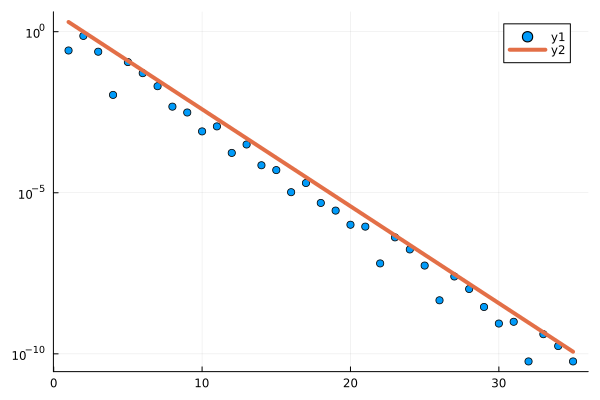

In [28]:
hist = bisect_iter(f, -1, 3, 1e-10)
r = hist[end] # What are we trusting?
hist = hist[1:end-1]
scatter( abs.(hist .- r), yscale=:log10)
ks = 1:length(hist)
plot!(ks, 4 * (.5 .^ ks))

Evidently the error $e_k = x_k - x_*$ after $k$ bisections satisfies the bound
$$ |e^k| \le c 2^{-k} . $$

# Convergence classes

A convergent rootfinding algorithm produces a sequence of approximations $x_k$ such that $$\lim_{k \to \infty} x_k \to x_*$$ where $f(x_*) = 0$.  For analysis, it is convenient to define the errors $e_k = x_k - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if $$\lim_{k \to \infty} |e_{k+1}| / |e_k| = \rho < 1.$$  (The $q$ is for "quotient".)  A smaller convergence factor $\rho$ represents faster convergence.  A slightly weaker condition ($r$-linear convergence or just **linear convergence**) is that
$$ |e_k| \le \epsilon_k $$
for all sufficiently large $k$ when the sequence $\{\epsilon_k\}$ converges $q$-linearly to 0.

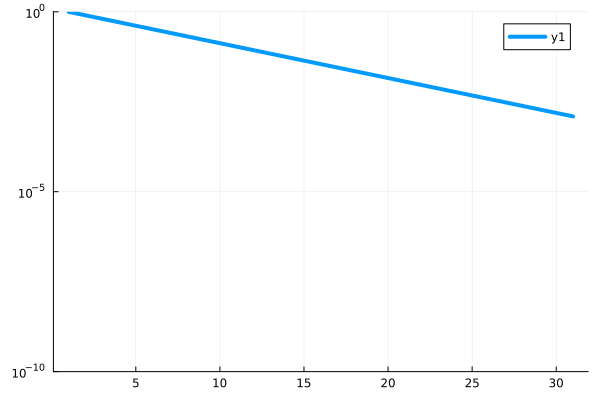

In [29]:
ρ = 0.8
errors = [1.]
for i in 1:30
    next_e = errors[end] * ρ
    push!(errors, next_e)
end
plot(errors, yscale=:log10, ylims=(1e-10, 1))

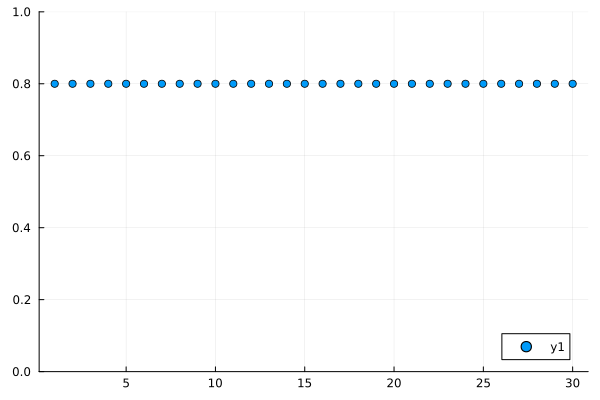

In [30]:
e = hist .- r
scatter(abs.(errors[2:end] ./ errors[1:end-1]), ylims=(0,1))

## Bisection: A = q-linearly convergent, B = r-linearly convergent, C = neither

# Remarks on bisection

* Specifying an interval is often inconvenient
* An interval in which the function changes sign guarantees convergence (robustness)
* No derivative information is required
* If bisection works for $f(x)$, then it works and gives the same accuracy for $f(x) \sigma(x)$ where $\sigma(x) > 0$.
* Roots of even degree are problematic
* A bound on the solution error is directly available
* The convergence rate is modest -- one iteration per bit of accuracy

## For you

* Share an equation that is useful for one task, but requires rootfinding for another task.
* OR: explain a system in which one stakeholder has the natural inputs, but a different stakeholder only knows outputs.

Please collaborate.